In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


# Heart Disease

# **Research Question:** How do a person’s health factors influence the likelihood of that person having a heart disease? 

# Introduction

Heart disease is a broad term for many heart conditions. A person can go undiagnosed for most of their life until they experience a major symptom such as a heart attack or even heart failure. Many personal health factors can affect their risk of having a heart disease. This includes, cholesterol, age, and sex.  
When analyzing this data, it is intended to find what health factors can affect a person’s chance of having heart disease. 


Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


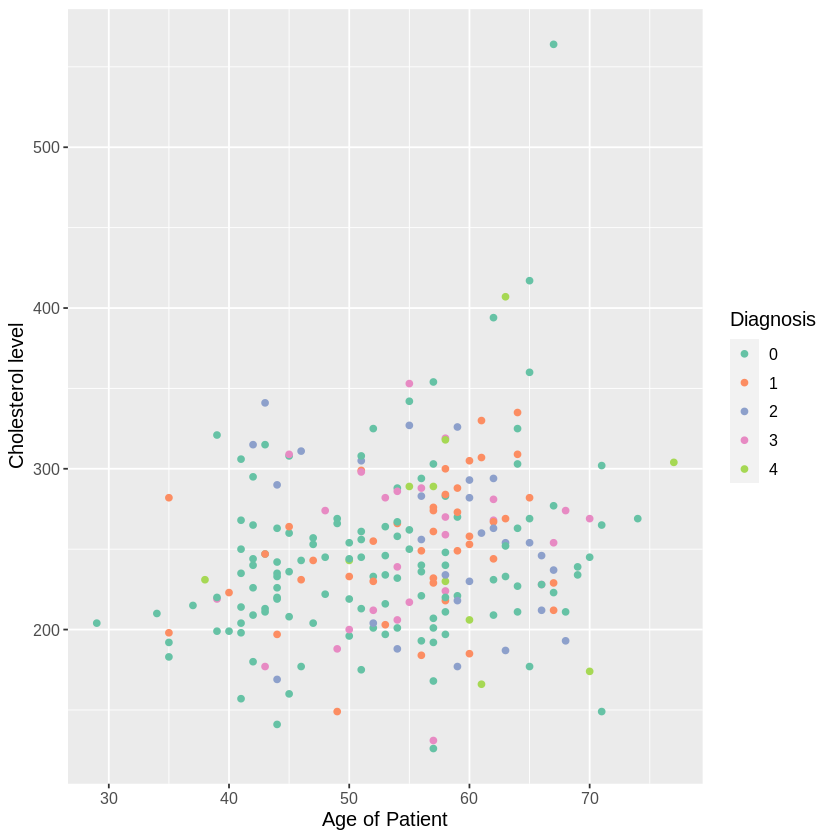

In [36]:
heart_disease <- read_csv("heart_disease.data", col_names=FALSE) %>%
    rename(age = X1,
            sex = X2,
          cp = X3,
          trestbps = X4,
          chol = X5,
          fbs = X6,
          restecg =X7,
          thalach = X8,
          exang =X9, 
          oldpeak =X10,
          slope =X11,
          ca = X12,
          thal = X13,
          num = X14) %>%
    mutate(num = as_factor(num))

heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = num)
disease_train <- training(heart_disease_split)


heart_disease_plot<-ggplot(disease_train, aes(x = age, y = chol, color = num)) +
geom_point() +
labs(x = "Age of Patient",
y = "Cholesterol level",
color = "Diagnosis") +
theme(text = element_text(size = 12)) +
scale_color_brewer(palette = "Set2")

disease_train
heart_disease
heart_disease_plot

# Methods

The main columns that will be used are age and cholesterol level. They will be compared to the other factors to see which ones correlate the most. The main comparison will be how age and sex can compared.

We decided to create groupings of the num or predicted attributes. There were five categories originally and we combined them to create three. The first was a not at risk group which consisted of the zero category. We combined the level one and two categories to create a moderately at risk group, and the three and four levels to create an at high risk group. The not at risk group would have no risk of heart disease and would not require treatment. The moderately at risk group would have a risk of heart disease, but would not require as agressive of treatment. The highly at risk group would have a risk of heart disease and would require extensive treatment. 


# Expected Outcomes and Significance

We expect that age and cholesterol level will be significant predictors of heart disease. We expect that there will be a positive relationship between these predictors and occurence rate of heart disease. 

Predicting which factors raise a person's likelihood for heart disease allows medical professionals to be more accurately informed and increases the chance for accurate diagnosis. As heart disease is one of the leading causes of death, early preventative and diagnostic action can lead to a decreased mortality rate.

Finally, a more accurate diagnosis of heart disease allows for more detailed research of its causes, as well as potential treatments. By prioritizing focus on those causes that play a more significant role, future research in the field may become more efficient and effective.